# Deep Learning on Wind Turbines Health Prediction Report

Written by: Vy Nguyen

# Goal
The project goal is to apply deep learning technique to predict, as accurately as possible, the operating mode of a wind turbine based on the time series data from two sensors.

# Context
In modern industrial applications, sensors are used to observe key machine characteristics.
These can help detect slight deviations and issues to avoid major system failures through
targeted repairs while keeping maintenance costs under control.

Such sensors are critical in the operation of wind turbines. Due to fluctuating winds that can negatively impact the turbines and the high costs of maintenance, specifically for offshore turbines, sensor readings need to be reliably converted into an operating mode. That is, given the sensor readings over time, we want to know whether the turbine is operating correctly or whether one of several issues is present. If issues are detected (reliably), targeted efforts can be made to alleviate them before a major system failure occurs.

# Data
- The data are sensor readings and operating modes for 4,000 turbine runs. 
- time_series_1 and time_series_2 are NumPy arrays of shape (4000,5000). 
- Each observation corresponds to 5,000 records of the turbine over time by one of the two sensors (time_series_1 measures the pitch angle in each second of operation, and time_series_2 measures the generator torque). 
- y is the operating mode for each of the 4,000 turbine runs (0 if the turbine is healthy, 1 if the generator torque is faulty, 2 if the pitch angle is faulty, and 3 if both are faulty). Note that the dataset is balanced in that each operating mode is represented equally often.

# Process
- Validation and test datasets consisting of 15% of the observations each for all task.

# Import libraries

In [2]:
# data handling & manipulation 
import pandas as pd 
import numpy as np 

# visualisation 
import matplotlib.pyplot as plt 
import seaborn as sns

# machine learning & neural networks 
import pickle
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, SimpleRNN, BatchNormalization, LSTM, Conv1D, Embedding, GRU
from tensorflow.keras.layers import Dropout, LSTM, Activation #, CuDNNLSTM
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.data import Dataset, TFRecordDataset
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, MaxPool2D
from tensorflow.keras.losses import mean_squared_error
from keras.utils.np_utils import to_categorical
from PIL import Image

# Pre-processing Data

In [3]:
# load data
with open('time_series_1.pickle','rb') as handle:
  time_series_1 = pickle.load(handle)
with open('time_series_2.pickle','rb') as handle:
  time_series_2 = pickle.load(handle)
with open('y.pickle','rb') as handle:
  y = pickle.load(handle)

In [4]:
# inspect data shape
print(time_series_1.shape)       # Pitch angle   
print(time_series_2.shape)       # Generator torque 
print(y.shape)

(4000, 5000)
(4000, 5000)
(4000,)


In [126]:
# change x type into float 32
time_1 = time_series_1.astype(np.float32)
time_2 = time_series_2.astype(np.float32)

In [127]:
# Categorise Signals (y)
# get X
X = np.stack((time_1,time_2),axis=2)

# one hot encoding
y_cat = to_categorical(y)

print(X.shape)
print(y_cat.shape)


(4000, 5000, 2)
(4000, 4)


In [128]:
# Scale Times Series (X)
# for loop for scaling 3d array with sklearn 
scalers = {}
for i in range(X.shape[1]):
    scalers[i] = StandardScaler()
    X[:, i, :] = scalers[i].fit_transform(X[:, i, :]) 
    
X[1]

array([[ 1.5288179 , -2.1278884 ],
       [ 2.0491924 ,  1.4974637 ],
       [ 1.3460252 , -1.9109731 ],
       ...,
       [ 0.36613974,  1.1211531 ],
       [ 0.51349765,  1.7557433 ],
       [-0.1652406 ,  1.7513107 ]], dtype=float32)

In [129]:
# Split data training, validation, and test sets
X_train, X_other, y_train, y_other = train_test_split(X, y_cat, train_size=0.7, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=1)


print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(2800, 5000, 2)
(2800, 4)
(600, 5000, 2)
(600, 4)
(600, 5000, 2)
(600, 4)


[[   0. 1000.]
 [   1. 1000.]
 [   2. 1000.]
 [   3. 1000.]]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


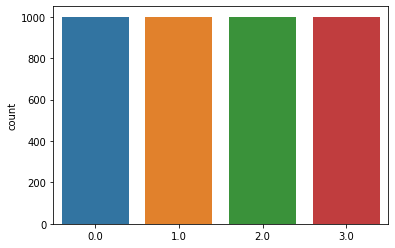

In [10]:
# inspect class distribution
sns.countplot(y)
unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts)).T)

In [11]:
# Function to Plot Train & Validation Loss
def train_plot(model,ep):

  # train model
  np.random.seed(1)
  tf.random.set_seed(1)

  model.compile(loss="categorical_crossentropy", 
                optimizer=Adam(learning_rate = 0.001,decay=1e-6),
                metrics=['accuracy'])
  
  log = model.fit(X_train,y_train, 
                  epochs = ep ,
                  validation_data=(X_valid,y_valid))
  
  # plot loss
  plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
  plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
  plt.legend()
  ax = plt.gca()
  plt.show()
    
  return model

# SimpleRNN, LSTM, and Conv1D models

- Create different models in TensorFlow to predict the operating mode of a wind turbine based on the two time series from the sensors. 
- Given data are sensor readings and operating modes for 4,000 turbin runs (X) and the according operating mode for each (y), the recurrent neural network is a sequence-to-vector network.
- The network is fed by a sequence of inputs and ignore all outputs except for the last one. 
- Store final validation set accuracy.

### Linear Regression

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 4)                 40004     
                                                                 
Total params: 40,004
Trainable params: 40,004
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
88/88 [==============================] - 1s 7ms/step - loss: 6.2868 - accuracy: 0.4000 - val_loss: 5.8942 - val_accuracy: 0.3550
Epoch 2/15
88/88 [==============================] - 0s 5ms/step - loss: 4.9303 - accuracy: 0.4086 - val_loss: 6.5526 - val_accuracy: 0.4550
Epoch 3/15
88/88 [==============================] - 0s 5ms/step - loss: 6.8777 - accuracy: 0.4068 - val_loss: 7.3160 - val_accuracy: 0.3483
Epoch 4/15
88/88 [==========

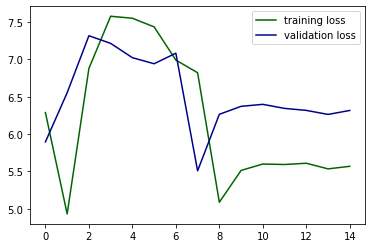

In [12]:
linear_model = Sequential([
    Flatten(input_shape= X.shape[1:]),
    Dense(4)
])
linear_model.compile(loss="sparse_categorical_crossentropy",metrics=['accuracy'])
linear_model.summary()
train_plot(linear_model,15)

### Simple RNN

In [ ]:
model_simple_RNN = Sequential()
model_simple_RNN.add(SimpleRNN(1, input_shape=X.shape[1:]))
model_simple_RNN.add(Dense(4, activation='softmax'))
model_simple_RNN.compile(loss="sparse_categorical_crossentropy",metrics=['accuracy'])

model_simple_RNN.summary()
train_plot(model_simple_RNN,15)

### Deep RNN

In [ ]:
model_deeper = Sequential()
model_deeper.add(SimpleRNN(15, return_sequences=True, input_shape=X.shape[1:]))
model_deeper.add(SimpleRNN(15))
model_deeper.add(Dense(4, activation='softmax'))

model_deeper.summary()
train_plot(model_deeper,15)

### Long Short Term Memory (LSTM) 

In [ ]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(15, return_sequences=True, input_shape= X.shape[1:]))
model_LSTM.add(LSTM(15))
model_LSTM.add(Dense(4, activation='softmax'))

model_LSTM.summary()
train_plot(model_LSTM,15)

### Conv1D

In [ ]:
model_conv1D = Sequential()
model_conv1D.add(Conv1D(filters=20,kernel_size=4,strides=2,padding="valid",input_shape=X.shape[1:]))
model_conv1D.add(GRU(15))
model_conv1D.add(Dense(4), activation ="softmax")

model_conv1D.summary()
train_plot(model_conv1D,15)

### GRUs

In [ ]:
model_gru = Sequential()
model_gru.add(GRU(15, return_sequences=True, input_shape= X.shape[1:]))
model_gru.add(GRU(15))
model_gru.add(Dense(4, activation ="softmax"))

model_gru.summary()
train_plot(model_gru,15)

# Scenario 2: CNNs model

## Why Convolutional Neural Network (CNNs) with 2D convolutional layers can help analyse time-series data and might outperform RNNs? 

For this to work, time series need to be converted into “images” (matrices of numbers). The paper “Convolutional neural network fault classification based on time series analysis for benchmark wind turbine machine” by Rahimilarki, Gao, Jin, and Zhang (published 2022 in “Renewable Energy” and available through the City-library) describes how two-dimensional CNNs can be applied to the problem at hand. Consider sections 4 and 5 that depict the process of converting one or multiple time series into “images” used within a CNN.

The goal of training a Convolution Neural Network (CNN) is to find the best filters to get the most relevant and important features, by sliding a filter across an image to produce multiple feature maps. The methodology used in this paper is to transform two time series into images and use CNN to classify sensor noises and actuator faults. The convolutional layer slides several kernels across a sequence and produce a feature map per kernel. Each kernel will detect a single short sequential pattern (no longer than the kernel size), and use the activation function to extract relevant details. The process continues with the pooling technique to reduce the image size (i.e., original time series size is 4000x5000x1 each). This is considered as a bonus of CNN approach as to speed up the process comparing to RNN. After retrieving all of the advanced features from each image, we combine them together to classify the image to proper labels.

Although RNN is commonly applied in dealing with sequential information (e.g., translation), the CNN method outweighs CNN considering the context and goal of the paper. As it is to detect minor faults of the wind turbine system, we are looking for the important features that usually found together with fault label, rather than search for relationships between adjacent pixels. Moreover, by dropping unimportant details, CNN may help detect longer patterns of sensor noises and actuator faults. By increasing the number of kernels can also improve the accuracy of training for a dataset with high-frequency variation. Hence, increasing the accuracy of the classification results.

As shown in below sections, the accuracy score of CNN is proved to be higher than RNN models.

## Approach: 
- Convert the data for use with a CNN
- In particular, following the approach outlined in Scenario 2 (section 5.3 of the paper) and summarized in Figure 18, convert the two time series corresponding to one wind turbine run into a single (100,100,1) array (i.e., a grayscale
image).

In [88]:
# change x type into float 32
time_1 = time_series_1.astype(np.float32)
time_2 = time_series_2.astype(np.float32)

# get X
X = np.stack((time_1, time_2),  axis=2)

# scale x
#x_scaled = X/255.0

# check shape 
print(x_scaled.shape)

(4000, 5000, 2)


In [89]:
# reshape 2 time series
series_1_reshape = time_1.reshape(time_1.shape[0], 100, 50)
series_2_reshape = time_2.reshape(time_2.shape[0], 100, 50)
x_reshape = np.concatenate((series_1_reshape, series_2_reshape), axis =2)
x_reshape.shape

(4000, 100, 100)

In [90]:
# split data into train, validation and test set
other_X_reshape, test_X_reshape, other_Y_reshape, test_Y_reshape = train_test_split(x_reshape, y_cat, test_size=0.15, random_state = 123)
train_X_reshape, valid_X_reshape, train_Y_reshape, valid_Y_reshape = train_test_split(other_X_reshape, other_Y_reshape, test_size=0.15/0.85, random_state = 123)

In [91]:
# reshape data for CNN
# change into shape (100,100,1)
x_train_reshape = train_X_reshape[..., np.newaxis]
x_valid_reshape = valid_X_reshape[..., np.newaxis]
x_test_reshape = test_X_reshape[..., np.newaxis]
# check shape 
print(x_train_reshape.shape)
print(x_valid_reshape.shape)
print(x_test_reshape.shape)

(2800, 100, 100, 1)
(600, 100, 100, 1)
(600, 100, 100, 1)


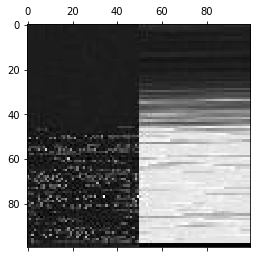

In [92]:
plt.matshow(x_reshape[0], cmap="gray")

- In TensorFlow, replicate the CNN with two convolutional layers displayed in Figure 12 and train it on your data, and record final validation set accuracy.\

In [22]:
# build model
cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3,3), input_shape = x_train_reshape.shape[1:]))
cnn_model.add(Conv2D(32, (3,3)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(16, (3,3)) )
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(3, 3)))

cnn_model.add(Flatten())  
cnn_model.add(Dense(4,activation='softmax'))

cnn_model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 dropout (Dropout)           (None, 96, 96, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 94, 94, 16)        4624      
                                                                 
 activation (Activation)     (None, 94, 94, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                      

In [23]:
# fit model
cnn_fit = cnn_model.fit(x_train_reshape,train_Y_reshape,epochs=40,
                      validation_data=(x_valid_reshape, valid_Y_reshape),
                      verbose=1)

Epoch 1/40
88/88 [==============================] - 115s 1s/step - loss: 14.3519 - accuracy: 0.2725 - val_loss: 1.3860 - val_accuracy: 0.2817
Epoch 2/40
88/88 [==============================] - 101s 1s/step - loss: 1.3902 - accuracy: 0.2693 - val_loss: 1.3862 - val_accuracy: 0.2350
Epoch 3/40
88/88 [==============================] - 101s 1s/step - loss: 1.3690 - accuracy: 0.3093 - val_loss: 1.3425 - val_accuracy: 0.3050
Epoch 4/40
88/88 [==============================] - 103s 1s/step - loss: 0.7815 - accuracy: 0.6850 - val_loss: 0.2833 - val_accuracy: 0.8817
Epoch 5/40
88/88 [==============================] - 97s 1s/step - loss: 0.3233 - accuracy: 0.8707 - val_loss: 0.2777 - val_accuracy: 0.8833
Epoch 6/40
88/88 [==============================] - 96s 1s/step - loss: 0.3360 - accuracy: 0.8621 - val_loss: 0.2815 - val_accuracy: 0.8867
Epoch 7/40
88/88 [==============================] - 96s 1s/step - loss: 0.2789 - accuracy: 0.8804 - val_loss: 0.2629 - val_accuracy: 0.8867
Epoch 8/40
88/8

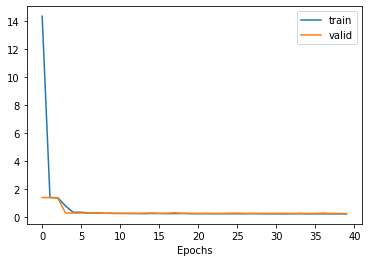

In [24]:
# visualise Training and Validation Loss
plt.plot(cnn_fit.history['loss'], label='train')
plt.plot(cnn_fit.history['val_loss'], label='valid')
plt.legend()
plt.xlabel('Epochs')
plt.show()

Text(0.5, 0, 'Epochs')

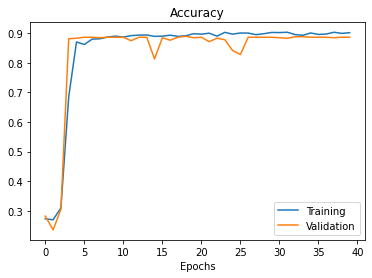

In [25]:
# visualise training and validation accuracy
plt.plot(cnn_fit.history['accuracy'])
plt.plot(cnn_fit.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epochs')

In [26]:
cnn_val_loss, cnn_val_acc = cnn_model.evaluate(x_test_reshape, test_Y_reshape)  # evaluate the out of sample data with model
print("Model's loss (error) is",cnn_val_loss)  # model's loss (error)
print("Model's accuracy is",cnn_val_acc)  # model's accuracy

19/19 [==============================] - 4s 222ms/step - loss: 0.2513 - accuracy: 0.8900
Model's loss (error) is 0.2512582540512085
Model's accuracy is 0.8899999856948853


# Creatively Designing CNNs model

In [54]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [55]:
# check X, y shape
print(x_train_reshape.shape, train_Y_reshape.shape)
print(x_valid_reshape.shape, valid_Y_reshape.shape)
print(x_test_reshape.shape, test_Y_reshape.shape)

(2800, 100, 100, 1) (2800, 4)
(600, 100, 100, 1) (600, 4)
(600, 100, 100, 1) (600, 4)


### Fit New Standardization Data

In [33]:
# feature standardization
x_standard = x_train_reshape

# define data preparation
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# fit parameters from data
datagen.fit(x_standard)

In [35]:
# fit CNN model with standardized data
cnn_aug_model = cnn_model.fit(x_standard, train_Y_reshape, epochs=5,
                              validation_data=(x_valid_reshape, valid_Y_reshape),
                              verbose=1)

Epoch 1/5
88/88 [==============================] - 97s 1s/step - loss: 0.2236 - accuracy: 0.8979 - val_loss: 0.2736 - val_accuracy: 0.8833
Epoch 2/5
88/88 [==============================] - 97s 1s/step - loss: 0.2201 - accuracy: 0.8993 - val_loss: 0.2638 - val_accuracy: 0.8867
Epoch 3/5
88/88 [==============================] - 106s 1s/step - loss: 0.2178 - accuracy: 0.9021 - val_loss: 0.2496 - val_accuracy: 0.8833
Epoch 4/5
88/88 [==============================] - 97s 1s/step - loss: 0.2103 - accuracy: 0.9007 - val_loss: 0.2762 - val_accuracy: 0.8883
Epoch 5/5
88/88 [==============================] - 115s 1s/step - loss: 0.2147 - accuracy: 0.9000 - val_loss: 0.2613 - val_accuracy: 0.8867


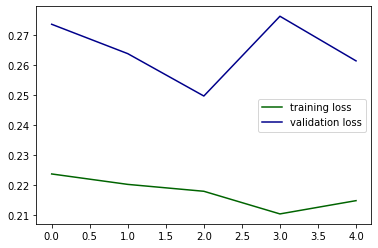

In [36]:
# plot training and validation loss
plt.plot(cnn_aug_model.history['loss'],label = "training loss",color='darkgreen')
plt.plot(cnn_aug_model.history['val_loss'], label = "validation loss",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()


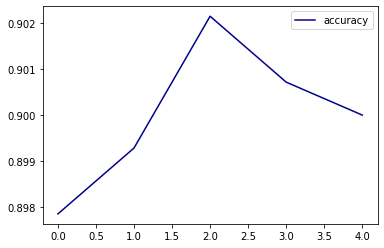

In [52]:
# plot accuracy
plt.plot(cnn_aug_model.history['accuracy'], label = "accuracy",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

In [50]:
# evaluate model
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(test_X_reshape, test_Y_reshape)

19/19 [==============================] - 4s 210ms/step - loss: 0.3467 - accuracy: 0.8600


- Compare the models created so far (both RNNs and CNNs) and make a selection on accuracy score.
- Train that model on a combined training and validation set and evaluate it on your test set.

### RNN Model

In [137]:
X_combined1 = np.concatenate((X_train,X_valid))
y_combined1 = np.concatenate((y_train,y_valid))

print(X_combined1.shape,y_combined1.shape)
print(X_test.shape, y_test.shape)

(3400, 5000, 2) (3400, 4)
(600, 5000, 2) (600, 4)


In [143]:
# train and evaluate RNN model
np.random.seed(1)
tf.random.set_seed(1)

rnn_model = model_deeper.fit(X_combined1, y_combined1, epochs=5,
                             validation_data=(X_test, y_test),verbose=1)


Epoch 1/5
107/107 [==============================] - 540s 5s/step - loss: 1.2785 - accuracy: 0.4074 - val_loss: 1.2611 - val_accuracy: 0.4250
Epoch 2/5
107/107 [==============================] - 520s 5s/step - loss: 1.2077 - accuracy: 0.4712 - val_loss: 1.2262 - val_accuracy: 0.4383
Epoch 3/5
107/107 [==============================] - 530s 5s/step - loss: 1.1610 - accuracy: 0.4997 - val_loss: 1.1972 - val_accuracy: 0.4650
Epoch 4/5
107/107 [==============================] - 533s 5s/step - loss: 1.1116 - accuracy: 0.5306 - val_loss: 1.1566 - val_accuracy: 0.4967
Epoch 5/5
107/107 [==============================] - 515s 5s/step - loss: 1.0741 - accuracy: 0.5544 - val_loss: 1.1225 - val_accuracy: 0.5067


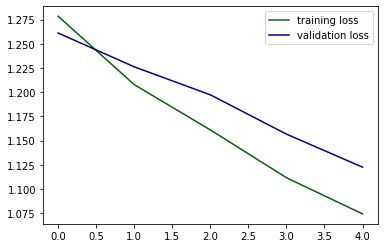

In [144]:
# plot loss
plt.plot(rnn_model.history['loss'],label = "training loss",color='darkgreen')
plt.plot(rnn_model.history['val_loss'], label = "validation loss",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

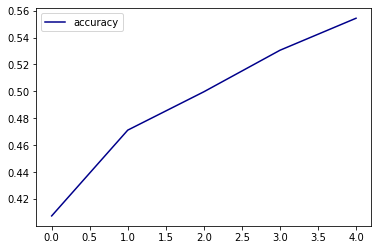

In [145]:
# plot accuracy
plt.plot(rnn_model.history['accuracy'],label = "accuracy",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

In [147]:
# evaluate model
rnn_test_loss, rnn_test_acc = model_deeper.evaluate(X_test, y_test)

19/19 [==============================] - 11s 548ms/step - loss: 1.1225 - accuracy: 0.5067


### CNN Model

In [ ]:
# check X, y shape
print(x_train_reshape.shape,train_Y_reshape.shape)
print(x_valid_reshape.shape,valid_Y_reshape.shape)
print(x_test_reshape.shape,test_Y_reshape.shape)

In [ ]:
X_combined = np.vstack([x_train_reshape,x_valid_reshape])
y_combined = np.vstack([train_Y_reshape,valid_Y_reshape])

print(X_combined.shape,y_combined.shape)

In [62]:
# train and evaluate CNN model
np.random.seed(1)
tf.random.set_seed(1)

cnn_final_model = cnn_model.fit(X_combined, y_combined, epochs=5,
                                validation_data=(x_test_reshape, test_Y_reshape),
                                verbose=1)

Epoch 1/5
107/107 [==============================] - 130s 1s/step - loss: 0.2254 - accuracy: 0.8971 - val_loss: 0.2493 - val_accuracy: 0.8900
Epoch 2/5
107/107 [==============================] - 131s 1s/step - loss: 0.2278 - accuracy: 0.8938 - val_loss: 0.2590 - val_accuracy: 0.8883
Epoch 3/5
107/107 [==============================] - 125s 1s/step - loss: 0.2214 - accuracy: 0.8991 - val_loss: 0.3286 - val_accuracy: 0.8650
Epoch 4/5
107/107 [==============================] - 129s 1s/step - loss: 0.2287 - accuracy: 0.8959 - val_loss: 0.2746 - val_accuracy: 0.8833
Epoch 5/5
107/107 [==============================] - 125s 1s/step - loss: 0.2218 - accuracy: 0.8997 - val_loss: 0.3074 - val_accuracy: 0.8850


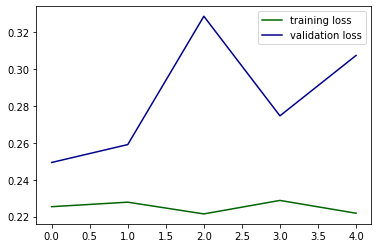

In [67]:
# plot loss
plt.plot(cnn_final_model.history['loss'],label = "training loss",color='darkgreen')
plt.plot(cnn_final_model.history['val_loss'], label = "validation loss",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

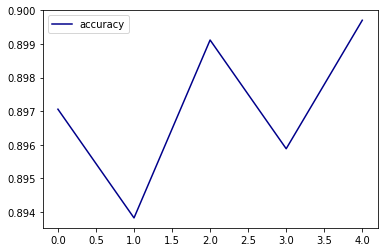

In [68]:
# plot accuracy
plt.plot(cnn_final_model.history['accuracy'],label = "accuracy",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

In [150]:
# evaluate model
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(test_X_reshape, test_Y_reshape)

19/19 [==============================] - 5s 239ms/step - loss: 0.3074 - accuracy: 0.8850


When evaluate between models, different metrics are used to examine the performance of the model. In this paper, based on the goal of the project, the model should present high frequency of detecting errors (i.e., sensor noises and actuator faults from the turbin system), as to prevent from occuring high-cost maintenance. The higher the accuracy level, the earlier the model can detect fault monitoring and get the right action in time. Moreover, the benefits of transforming time series to images has also mentioned in Q2 in improving accuracy when detecting faults. 

- The lowest accuracy of CNN is 0.894
- The lowest accuracy of RNN is 0.4074

CNN has outperformed RNN with more than 40%. CNN model is considered the most appropriate considering the goal and context of data. 

## Save to h5

In [161]:
cnn_model.save('/content/drive/MyDrive/Colab Notebooks/cnn_model.h5')